In [3]:
import numpy as np
import sklearn as sk
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import statistics as st
from sklearn.preprocessing import PolynomialFeatures
import csv
from statsmodels.nonparametric.smoothers_lowess import lowess


In [4]:
#Leemos el dataset 
data = open("dataset.csv")
dataRead = csv.reader(data) #guardo el dataset en una matriz (tiene los labels)
header = []
header = next(dataRead)
X = []
B = []
for row in dataRead:
    X.append(row[3:]) #guardo los ultimos 3 elementos de cada fila
    B.append(row[2]) #me guardo Ozono en B

In [18]:
#Definimos funciones para realizar LOESS
def estandarizarX(x,v):
    for i in range(len(x)):
        x[i] = (x[i] - v[i][0])/v[i][1]
    return x
def estandarizarMat(A):
    A = np.array(A)
    v=[]
    A = A.T
    for i in range(len(A)):
        v.append([st.mean(A[i]) ,st.variance(A[i])])
        A[i]=(A[i])/st.variance(A[i])
    return A.T , v

def armarW(A, x, q):
    w = np.zeros((len(A),len(A)))
    idx = vecinosidx(A,x,q) 
    d = np.linalg.norm(x-A[idx[q-1]]) #Distancia maxima
    for i in range(len(idx)):
        index = idx[i]
        n = (1-((np.linalg.norm(x-A[index]))/d)**3) ** 3
        w[index][index]= n   
    return w

def armarWLineal(A,x,q):
    w = np.zeros((len(A),len(A)))
    idx = vecinosidx(A,x,q) 
    d = np.linalg.norm(x-A[idx[q-1]]) #Distancia maxima
    for i in range(len(idx)):
        index = idx[i]
        n = (1-((np.linalg.norm(x-A[index]))/d))
        w[index][index]= n   
    return w
    

def vecinosidx (A,x,q):
    lista =[]
    for v in A:
        lista.append(np.linalg.norm(v-x))
    idx = np.argsort(lista)
    return idx[:q]
def armarA(X, g ):
    poly = PolynomialFeatures(g)
    B = poly.fit_transform(X)
    return B
#Dado un dataset obtengo el X y el B
def obtengoXyB(dataset):
    B = []
    X = []
    for i in dataset:
        B.append(i[0])
        X.append(i[1:])
    return X,B
#Definimos las funciones para generar dataset sintetico 
def funLineal(x):
    return x #Funcion lineal 

def funCuad(x):
    return x**2 
def funSen(x):
    return sin(x)

def crearY(x1):
    Y = np.zeros(len(x1),dtype = float)
    for i in range(len(Y)): 
        Y[i] = fun1(x1[i]) + np.random.normal(0,2000)
    return Y
    
def crearYSinRuido(x1):
    Y = np.zeros(len(x1),dtype = float)
    for i in range(len(Y)):
        Y[i] = fun1(x1[i])
    return Y

def datasetSintetico(): 
    #x1 = np.random.normal(100,5,111) 
    x1 = (np.random.uniform(90,110,111))
    x1 = np.sort(x1)
    YRuido = crearY(x1) 
    datasetRuido = [YRuido,x1]
    arDatasetRuido = np.array(datasetRuido)
    arDatasetRuido = arDatasetRuido.T
    YSinRuido = crearYSinRuido(x1) 
    datasetSinRuido = [YSinRuido,x1]
    arDatasetSinRuido = np.array(datasetSinRuido)
    arDatasetSinRuido = arDatasetSinRuido.T
    return arDatasetRuido, arDatasetSinRuido
#Funcion de experimento. Esta genera un vector res que son las aproximaciones que luego 
#compararemos con los valores reales
def loess(dataset,q,grado):
    X,B = obtengoXyB(dataset)
    X = np.array(X)
    B = np.array(B)
    A = armarA(X,grado)
    res =[]
    
    for i in range(len(A)):
        W = armarW(np.array(X),np.array(X[i]),q)
        x = (np.linalg.pinv((A.transpose() @ W) @ A) @ A.transpose() @ W) @ B
        res.append((x.T @ A.T)[i])
    return res


#Estima un solo punto
def estimar (dataset, K,q,grado):
    X,B = obtengoXyB(dataset)
    A = armarA(X,grado)
    res =[]
    K_=[]
    K = np.array(K)
    W = armarW(np.array(X),K,q)
    K = K.reshape(1,-1)
    theta = (np.linalg.pinv((A.T @ W) @ A) @ A.T @ W) @ B
    A_ = armarA(K,grado)
    res.append((theta.T @ A_.T))
    return res[0]

def errorPorcentaje(B,residual):
    res = []
    for i in range(len(B)):
        res.append((residual[i]/B[i])*100)
    return res
def datasetSinLabels(dataset):
    res = []
    for i in dataset:
        res.append(i[2:])
    return res
#Acá variamos el numero de Q que tenemos. 
def evaluoFuncionQ(dataset,q):
    X, B = obtengoXyB(dataset)
    B = modificarDataset(B)
    res = experimento(dataset,q,2)
    residual = (B-np.array(res))
    residualAbs= (abs(residual))
    for i in range(len(residualAbs)):
        residualAbs[i]=(residualAbs[i]/abs(B[i]))*100
    res = residualAbs.mean()
    return res
def variarQHasta(n):
    res = []
    q = 2
    while q <= n:
        res.append(evaluoFuncionQ(q))
        q = q + 1
    return res

In [124]:

#Aca dado el dataset de la catedra, fijamos el valor de viento 
#Deberia ser generalizable, pero modificando la funcion, se puede experimentar con todas las medidas
#Para los distintos experimentos esta funcion se vio modificada.
def loessFijando(q,g,x1,x2):
    data = open("dataset.csv")
    dataRead = csv.reader(data) #guardo el dataset en una matriz (tiene los labels)
    header = []
    header = next(dataRead)
    X = []
    B = []
    for row in dataRead:
        X.append(row[3:]) #guardo los ultimos 3 elementos de cada fila
        B.append(row[2]) #me guardo Ozono en B
    X = [list(map(float, x)) for x in X]
    B = list(map(float, B))
    B = np.cbrt(B)
    mu = st.mean(B)
    sig= st.variance(B)
    for j in range(len(B)):
        B[j] = (B[j])/sig
    X,v = estandarizarMat(X)
    A = armarA(X,g)
    res =[]
    for i in range(20): #loop que fija cositas 
        K = np.array([x1,x2,i]) #x1 radi x2 temp x3 viento
        K_=[]
        for n in range (len(K)):
            m = (K[n])/v[n][1]
            K_.append( m)
        K_ = np.array(K_).reshape(1,-1)
        W = armarW(np.array(X),np.array(K_),q)
        theta = (np.linalg.pinv((A.T @ W) @ A) @ A.T @ W) @ B
        A_= armarA(K_,g)
        res.append((theta.T @ A_.T)[0]*sig)
    return res

In [125]:
#Estimacion Lineal
X = np.random.normal(10,10,100)
B = X 
dataset = np.array([X,B])
dataset = dataset.T
res = []
dif = []
K = np.random.normal(0,5,10)
K.sort()
for i in range (10):
    auxK = [K[i]]
    est = estimar(dataset,auxK,10,1)[0]
    res.append(est)
    dif.append(est - K[i]) 

[-8.003717132844928, -3.095424636180228, -1.236358648269632, -1.1676256649874877, 0.08307428421326597, 0.48622105395575044, 1.2905110615885862, 3.2359866089750735, 7.508533001082333, 7.673567371362021]
[-8.00371713 -3.09542464 -1.23635865 -1.16762566  0.08307428  0.48622105
  1.29051106  3.23598661  7.508533    7.67356737]


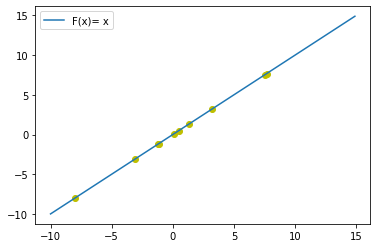

In [126]:
x = np.arange(-10,15,0.1)
y = x 
plt.plot(x,y)
plt.legend(["F(x)= x"])
plt.scatter(K,res, color = 'y')


In [127]:
# Estimacion Cuadratica
X = np.random.normal(10,10,100)
X.sort()
B = X**2
dataset = np.array([B,X])
dataset = dataset.T
res = []
dif = []
K = np.random.normal(0,5,10)
K.sort()
for i in range (10):
    auxK = [K[i]]
    est = estimar(dataset,auxK,10,2)[0]
    res.append(est)
    dif.append(est - K[i]**2) 

[40.34857170873095, 23.54033343026114, 4.258100934920534, 4.123979408561493, 3.568793739652354, 18.321768741364675, 27.67645851396657, 29.05673550050551, 30.613682030207784, 52.57676700190326]
[40.34857171 23.54033343  4.25810093  4.12397941  3.56879374 18.32176874
 27.67645851 29.0567355  30.61368203 52.576767  ]


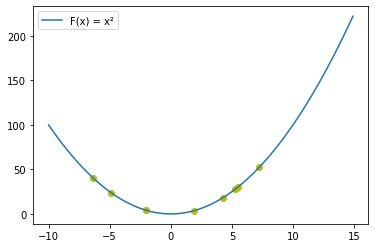

In [128]:
x = np.arange(-10,15,0.1)
y = x**2 
plt.plot(x,y)
plt.legend(["F(x) = x²"])
plt.scatter(K,res, color = 'y')

In [129]:
# Estimacion Seno
X = np.random.normal(10,10,100)
X.sort()
B = np.sin(X)
dataset = np.array([B,X])
dataset = dataset.T
res = []
dif = []
K = np.random.normal(0,5,10)
K.sort()
for i in range (10):
    auxK = [K[i]]
    est = estimar(dataset,auxK,10,2)[0]
    res.append(est)
    dif.append(est - np.sin(K[i])) 

[0.32579937535953807, 0.676160390141658, -0.6481508909517439, -0.07612230395933696, 0.3385093732748494, 0.6791117090055273, 0.9487381227020071, 0.9606472089985885, 0.9754632613027119, 0.19246398429486078]
[ 0.51175353  0.90772629 -0.58270639 -0.16748815  0.39838282  0.75749605
  0.97958648  0.99195076  0.98534684  0.21021533]


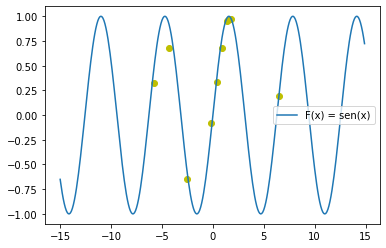

In [130]:
x = np.arange(-15,15,0.1)   # start,stop,step
y = np.sin(x)
plt.plot(x,y)
plt.legend(["F(x) = sen(x)"])
plt.scatter(K,res, color = 'y')

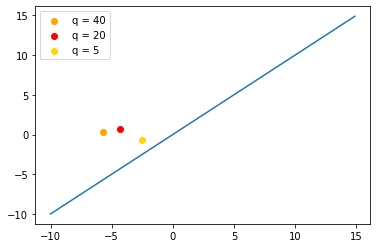

In [145]:
x = np.arange(-10,15,0.1)
y = x 
plt.plot(x,y)
plt.legend(["F(x)= x"])
c = ['orange','r','gold']
l = ['q = 40','q = 20','q = 5']
for i in range(3):
    plt.scatter(K[i],res[i], c = c[i], label= l[i])
    
leg1 = plt.legend(loc='upper left')


In [183]:
# Experimento 3
#Estimacion Lineal
X = np.random.normal(10,10,100)
B = X 
dataset = np.array([X,B])
dataset = dataset.T
errores = []
for i in range(2,len(X)):
    est = loess(dataset,i,2)
    residual = abs(B-est)
    errores.append(np.array(errorPorcentaje(B,residual)).mean())
    
print(errores)
q = np.arange(2,100)
plt.plot(q,errores)

[2.528017350174541e-14, 8.386093483331347e-06, 0.00048137745425839615, 7.196312856837108e-06, 1.021213748307532e-06, 1.1152955022018218e-07, 1.3641224410507007e-08, 5.442406332676115e-09, 1.8900379683714837e-09, 8.416429114911598e-10, 5.855731700507302e-10, 4.253223907434522e-10, 2.437720279184929e-10, 1.3231732001242104e-10, 1.3434940626339932e-10, 1.0225973808794297e-10, 7.181391742596088e-11, 6.537410040731488e-11, 7.523332296476674e-11, 5.055182247639977e-11, 4.9044938962459733e-11, 3.801490321591586e-11, 3.8829508895921225e-11, 4.117115515286764e-11, 2.793987223572374e-11, 2.993401812423808e-11, 3.6119986121880325e-11, 3.106618136575466e-11, 2.5368662027192353e-11, 3.673406951106796e-11, 2.066328377326377e-11, 4.105381910639576e-11, 3.563785907676412e-11, 5.5740253157384486e-11, 3.7100080954083593e-11, 3.742302517455325e-11, 1.4214918586168145e-11, 2.0190557996293752e-11, 1.1221674245169144e-11, 6.016784107267074e-11, 3.222432139599958e-11, 2.7278624522168808e-11, 5.20451335291867

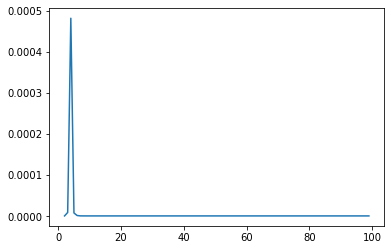

In [21]:
#Estimacion Cuadratica
X = np.random.normal(0,15,100)
X.sort()
B = X**2
dataset = np.array([B,X])
dataset = dataset.T
errores = []
for i in range(2,len(X)):
    est = loess(dataset,i,2)
    residual = abs(B-est)
    errores.append(np.array(errorPorcentaje(B,residual)).mean())

print(errores)
q = np.arange(2,100)
plt.plot(q,errores) 

[407.1764825140097, 407.1764821007362, 405.49113004506137, 371.9532176660376, 412.4073728499731, 206.42449725233945, 193.050500563949, 545.7816994620705, 513.0078811029454, 658.6502522291192, 639.8915335271703, 647.8527041781933, 625.336785485818, 733.8217157162795, 828.4973455458507, 895.9723459304895, 982.0795200848338, 1058.533537146334, 1148.0422163874653, 1156.1854150023437, 1204.1429952177018, 1264.7377500249158, 1341.3647875361423, 1344.6584575226523, 1349.0964461426058, 1365.718749037052, 1363.3541793583106, 1351.6711835243518, 1340.0643279524975, 1316.3026817550124, 1301.8097533023642, 1286.6444292876652, 1279.8368476501685, 1275.360482397652, 1264.8434501368165, 1255.9801534748462, 1252.3409861648963, 1249.8322852743906, 1245.1556226430416, 1235.704010041299, 1232.2769460082156, 1227.5547180547183, 1222.6261070385021, 1221.0280665500284, 1209.918111253, 1199.4910874788804, 1199.2102904530009, 1198.3000688647583, 1201.9930797572322, 1202.1021062466186, 1206.6802705403381, 1209

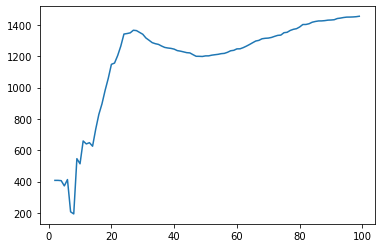

In [51]:
#Estimacion Seno
X = np.random.normal(10,10,100)
B = np.sin(X) 
dataset = np.array([X,B])
dataset = dataset.T
errores = []
for i in range(2,len(X)):
    est = loess(dataset,i,2)
    residual = B-est
    errores.append(np.array(errorPorcentaje(B,residual)).mean())

print(errores)
q = np.arange(2,100)
plt.plot(q,errores) 

100.44109372564954


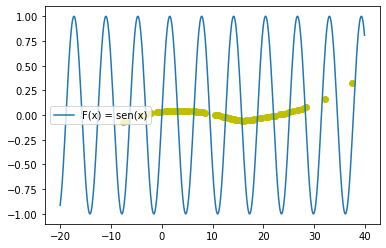

In [100]:
X = np.random.normal(10,10,100)
X.sort()
B = np.sin(X)
dataset = np.array([B,X])
dataset = dataset.T
res = []
dif = []
error = []
for i in range (100):
    auxK = [X[i]]
    est = estimar(dataset,auxK,100,2)[0]
    res.append(est)
    dif.append(est - np.sin(X[i])) 
    error.append(abs(dif[i]/np.sin(X[i])*100))
x = np.arange(-20,40,0.1)   # start,stop,step
y = np.sin(x)
plt.plot(x,y)
plt.legend(["F(x) = sen(x)"])
plt.scatter(X,res, color = 'y')
print(np.mean(error))